# Tasty bytes - predicting popular recipes

This notebook, part of the Professional Data Scientist certification, is a first attempt to predict which recipes will be popular for the Tasty Bites company.

# Data validation

## Data import and data types
Let's start by reading the data and checking what type of information they contain

In [124]:
import pandas as pd

df = pd.read_csv("recipe_site_traffic_2212.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


Compared to the expected data types, we can note that:
- recipe, calories, carbohydrate, sugar and protein **are supposed to be numerical and haven been imported as so**
- **category is in string format as expected**
- servings **should be numeric but here it is imported as string**. We shall look further into that
- high-traffic **is string as per the instructions**. We also see significant amount of missing values, which is coherent with the instructions (only popular recipes are flagged)

We can also see **some missing data for the nutritional columns** (calories, carbohydrate, sugar and protein), which we will treat soon.

First let's take a look at the data present in the table.

In [125]:
df.head(5)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


## Recipe field - a possible index?

The instructions say that the **recipe column is a unique identifier**. Let's check for that and in case positive reindex the dataframe

In [126]:
df["recipe"].duplicated().sum()

0

In [127]:
df = df.set_index("recipe")
df.sample(5)

NameError: name 'df' is not defined

## Validating nutritional data (calories, carbohydrate, sugar and protein)

We have seen from the above that these columns **are already on numeric types**, which validates the instructions given for these fields. Let's check their distributions

In [128]:
df[["calories", "carbohydrate", "sugar", "protein"]].describe()

,calories,carbohydrate,sugar,protein
count,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296
std,453.020997,43.949032,14.679176,36.369739
min,0.140000,0.030000,0.010000,0.000000
25%,110.430000,8.375000,1.690000,3.195000
50%,288.550000,21.480000,4.550000,10.800000
75%,597.650000,44.965000,9.800000,30.200000
max,3633.160000,530.420000,148.750000,363.360000


We can already see high variabilities (large distances min - p25 and p75 - max ) which potentially **indidates presence of outliers** (to be checked soon in Data Exploration phase).

We can also inspect that there is missing data for these columns.

In [129]:
df.isna().sum()

calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

In [130]:
print("A share of {0:.0%} entries are missing nutritional values in the dataset".format(df["calories"].isna().sum() / df.shape[0]))

A share of 5% entries are missing nutritional values in the dataset


In the pre-processing phase we shall **evaluate and implement ways to deal with this missing data**. 

## Validating categries

Let's take a look at categories used

In [131]:
df["category"].value_counts()

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64

In [132]:
print("A total of {} categories are in use".format(len(df["category"].unique())))

A total of 11 categories are in use


We **expected to see 10 categories and not 11**. From inspection from instructions we can see that the additional category is "Chicken Breast". 

Let's **replace this extra category**, allocating its entries to the "Chicken" category which is their natural generalization amongst available categories.

In [133]:
df["category"] = df["category"].str.replace("Chicken Breast", "Chicken")
df["category"].value_counts()

Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Vegetable         83
Dessert           83
Meat              79
One Dish Meal     71
Name: category, dtype: int64

## Validating servings

As seen before, we should have a numeric value in this column. Let's see why wasn't it imported as so:

In [134]:
df["servings"].value_counts()

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

There we have it. Three entries in the column have a string attached to them. Let's check if the "as a snack" information is already contained in the category column (there is a category for snacks):

In [135]:
df.loc[df["servings"].str.contains("as a snack"), ["servings", "category"]]

,servings,category
recipe,,
452,4 as a snack,Lunch/Snacks
549,6 as a snack,Lunch/Snacks
736,4 as a snack,Lunch/Snacks


Indeed, these entries are **already flagged in the correct category**. Therefore we can move ahead by **remving this redundant information** from the servings feature and convert it to int.

In [136]:
df["servings"] = df["servings"].str.replace(" as a snack", "", regex = False)
df["servings"] = df["servings"].astype(int)

## Validating high-traffic

Let's first check the entries for the column:

In [137]:
df["high_traffic"].value_counts()

High    574
Name: high_traffic, dtype: int64

In [138]:
print("A share of {0:.0%} of entries is flagged as high_traffic".format(1 - df["high_traffic"].isna().sum() / df.shape[0]))

A share of 61% of entries is flagged as high_traffic


As expected from instructions **only entries with high traffic are flagged**. 

Let's convert this column to a suitable type, in this case as we need only 2 values we use a boolean.

In [139]:
import numpy as np
df["high_traffic"] = df["high_traffic"].map({"High" : True, np.nan : False})

## The validated dataframe

After all this cleaning, let's have a look at the resulting dataframe, which we shall henceforth call recipes.

In [140]:
recipes = df
recipes.sample(5)

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
674,15.79,11.89,5.08,3.75,Vegetable,4,True
51,293.36,19.16,9.40,1.32,Pork,2,False
193,1243.90,74.77,0.75,8.20,Lunch/Snacks,2,False
838,12.63,40.82,0.59,3.41,Vegetable,4,True
190,529.68,23.75,2.28,15.81,Breakfast,1,True


# EDA - Exploratory Data Analysis

## Nutritional data

Let's begin by looking at the nutritional variables in a box plot to understand their skewness and outlier situation

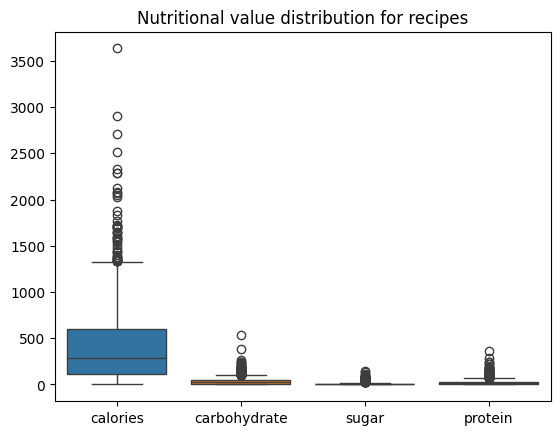

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

nutritional_features = ["calories", "carbohydrate", "sugar" , "protein"]

ax = sns.boxplot(data = recipes[nutritional_features])
ax.set_title("Nutritional value distribution for recipes")
plt.show()

For the total calories category we can see **significant presence of far-out outliers**. Taking into account that the recommended calory intake for adults is around 2.000 calories per day, the recipe at 3500+ calories is a bomb!

Maybe this column represent the total amount of calories of all the servings? If that is so we should expect to see the calories feature increase with the increase of servings:

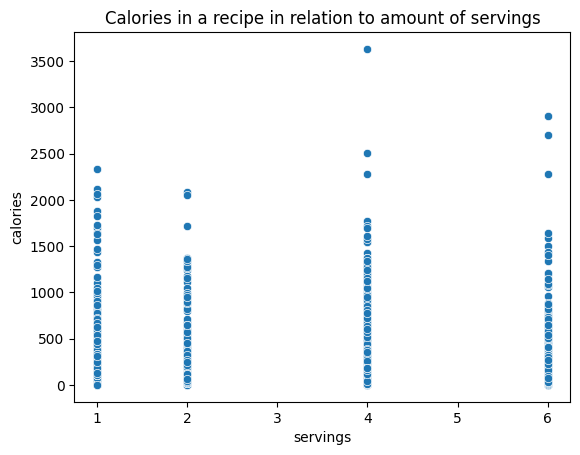

In [142]:
ax = sns.scatterplot(data = recipes, x = "servings", y = "calories")
ax.set_title("Calories in a recipe in relation to amount of servings")
plt.show()

Not really... It seems **Calories contain the "per serving calories" information**.

Let's see the distribution in this feature, which is important to evaluate scaling techniques (done further in this notebook)

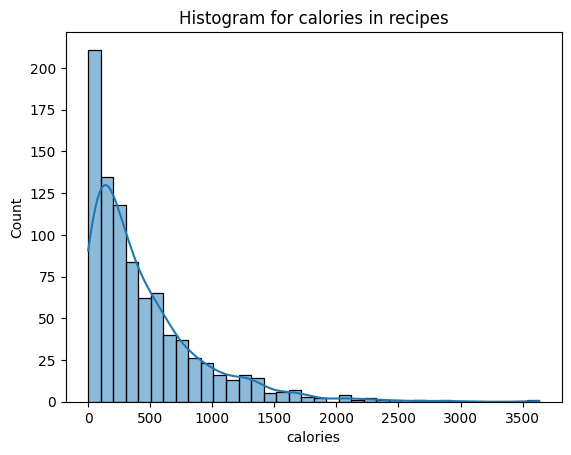

In [143]:
ax = sns.histplot(data = recipes, x = "calories", kde = True)
ax.set_title("Histogram for calories in recipes")
plt.show()

We can see the distribution is not very simetrical considering the high value outliers. This means the buckets are so small to display all the data that we don't see a "bell curve" shape in the above graph. We shall certainly **scale these nutritional features to standardize them**.

We have seen that category and servings have some representation on all categorical classes. Let's leave the single variable exploration for now and look at the possible relations between features

## Relation between features

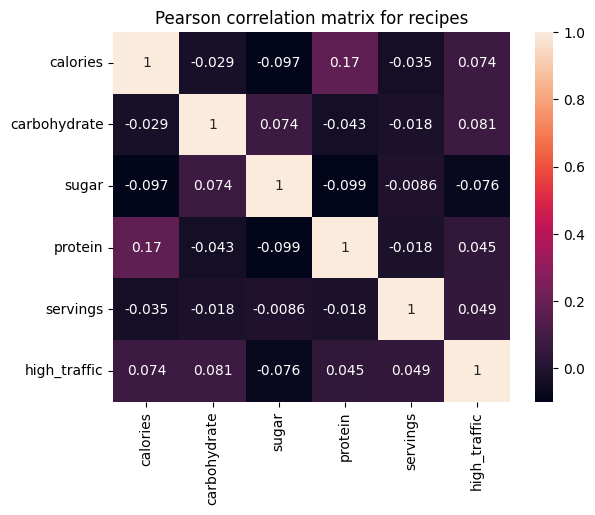

In [144]:
ax = sns.heatmap(recipes.corr(), annot=True)
ax.set_title("Pearson correlation matrix for recipes")
plt.show()

We can see very **little significant correlations overall**. The most correlated variables seem to be protein and calories, altough the Pearson correlation value is not very high (0.17).

Inspecting relations to "high_traffic" we see that **no single feature has high correlation**. Excited to see how machine learning can help us uncover more complex interplay between them to generate good recommendations.

# Pre-processing
## Dealing with missing data

We have seen earlier that we have **around 5% entries missing nutritional values**. In such scenario, removing such entries would not implicate in a significant loss of entries. 

However, to do so we would need to make sure that these 5% of entries are not biased (i.e. if the missing data is at random). We can check this with the PM team later on, for now we decide to keep them and **input with the median of each nutrition column**. The choice of median (instead of mean) is guided by the outliers and skewness identified earlier.

In [145]:
recipes_nona = recipes.fillna(recipes.median())
print("Missing nutritional values in recipes: {}".format(recipes_nona.isna().sum().sum()))

Missing nutritional values in recipes: 0


## Scaling

Given the presence of outliers and skewness of the data, it is likely that a MinMax scaler, although able to keep values as positive, would "compress" significantly the distribution. The alternative (to keep amongst the simple scalers we covered in course) could be a standard scaler.

In a first evaluation we shall look at a **standard scaler**, to be revised in case models take long to converge or don't converge at all.

The scaling step shall be incorporated directly into each model's pipeline.

## Dummies for categorical data

The categories at hand are non ordinal (meaning we can't encode them with a number). In this case we can use dummy categories

In [146]:
cat_dummies = pd.get_dummies(recipes_nona["category"], prefix = "cat")
recipes_dum = recipes_nona.drop("category", axis = 1).join(cat_dummies)
recipes_dum.sample(3)

,calories,carbohydrate,sugar,protein,servings,high_traffic,cat_Beverages,cat_Breakfast,cat_Chicken,cat_Dessert,cat_Lunch/Snacks,cat_Meat,cat_One Dish Meal,cat_Pork,cat_Potato,cat_Vegetable
recipe,,,,,,,,,,,,,,,,
504,529.26,100.70,5.88,9.6,4,True,0,0,0,0,0,0,0,0,0,1
137,288.55,21.48,4.55,10.8,2,True,0,0,0,0,0,0,1,0,0,0
582,288.55,21.48,4.55,10.8,1,False,0,0,1,0,0,0,0,0,0,0


## Train and test split

Time to split the data in training and testing. We shall start with a normal value (around 20% test).

In [147]:
from sklearn.model_selection import train_test_split

X = recipes_dum.drop("high_traffic", axis = 1)
y = recipes_dum["high_traffic"]

# Share of dataset that shall be used to train
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=42)
X_train.shape

(757, 15)

# A predictive model for high traffic recipes

## Problem definition and potential models

We need to predict which recipes will lead to high traffic. Given that high traffic is noted with a one value identifier, we have a **binary classification** problem at hands. 

In these situations, a **baseline model can be a simple recommendation of the highest frequency category** in "high_traffic". Given that "high_traffic" account for roughly 61% of recipes, our baseline is that.

To improve these results and generate insights to business, our plan is to test:
- **Linear regression model**: to incorporate the features in the equation and check their combined independent contributions
- **Logistics regression model**: which is often a good choice for binary classification models

In case these algorithms fail to get to the desired precision, we can look at more complex implementations such as **binary tree classifiers** or **ensemble methods**.



## Storing model performance information

In [148]:
true_ps = {}
false_ps = {}
accuracies = {}

## Defining performance of predictions

In this specific case, we have been requested to identify **which recipes will lead to high traffic**, meaning when we make a prediction about a recipe being a candidate for high traffic, we don't want make mistakes often. This is our business priority, since recipes flagged as not high traffic won't impact business.

In order words we are trying to **minimize False Positives**. The phrase _"Correctly predict high traffic recipes 80% of the time?"_ can therefore be interpreted as **"Contain False Positive rates to 20% maximum"**. 

In our performance assessment we whall also display predictions in a **confusion matrix**, allowing to check for type I and II errors alongside true positives and true negative rates.

In [149]:
from sklearn.metrics import accuracy_score, confusion_matrix

def calculate_performance(y_test, y_pred, verbose = True):
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, normalize = 'all')
    true_p = cm[1, 1]
    false_p = cm[0,1]
    cm_df = pd.DataFrame(data = cm, index = ["Actual - Low", "Actual - High"], columns = ["Predicted - Low", "Predicted - High"])
    if verbose:
        print("Recipes have been predicted correctly {:.2%} of times.".format(acc))
        print("True positive rate: {:.2%}".format(true_p))
        print("False positive rate: {:.2%}".format(false_p))
        print("Confusion matrix:")
        print(cm_df.to_string(float_format = lambda x: '{:.1%}'.format(x)))
        print()
    return true_p, false_p, acc

## Baseline model: a "constant" classifier

As seen, a baseline of simply predicting the most frequent category should result in 61% precision for a start. Although this model has no business use (it doesn't help to understand which features will lead to high traffic), it shall serve as a base performance.

In this case given that no train is needed we can calculate predictions and precision using the entire dataset.

In [150]:
# Find highest frequency category
highest_freq_cat = recipes["high_traffic"].value_counts(normalize = "all").sort_values(ascending = False).head(1).index[0]

baseline_prediction = [highest_freq_cat] * recipes.shape[0]
target = recipes["high_traffic"].to_list()

true_ps["base"] , false_ps["base"], accuracies["base"] = calculate_performance(target, baseline_prediction)

Recipes have been predicted correctly 60.61% of times.
True positive rate: 60.61%
False positive rate: 39.39%
Confusion matrix:
               Predicted - Low  Predicted - High
Actual - Low              0.0%             39.4%
Actual - High             0.0%             60.6%



## Linear regression classifier

Let's now incorporate the linear contribution of the features in a linear regression model.

Here the model will return a float, looking at True values as 1 and False as 0. We will have to encode into a boolean, which we shall do by separating the values via a threshold (default choice is 0.5).

In [151]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pipe_lin = make_pipeline(StandardScaler(), LinearRegression())
pipe_lin.fit(X_train, y_train)
y_pred = pipe_lin.predict(X_test)
y_pred = y_pred > 0.5
true_ps["linear"], false_ps["linear"], accuracies["linear"] = calculate_performance(y_test, y_pred)

Recipes have been predicted correctly 75.79% of times.
True positive rate: 47.89%
False positive rate: 12.63%
Confusion matrix:
               Predicted - Low  Predicted - High
Actual - Low             27.9%             12.6%
Actual - High            11.6%             47.9%



Interestling enough, we have seen the overall **accuracy of the model increase by more than 10%** compared to baseline, while the **True Positive rate has decreased**: normal due to not flagging all recipes as high traffic.

We can see that already in the linear model our **False Positive rate is below the 20%** requested by business. Let's see if we can improve that yet.

## Logistics regressor classifier

Now let's use a model which is optimized to binary predictions

In [152]:
from sklearn.linear_model import LogisticRegression

pipe_log = make_pipeline(StandardScaler(), LogisticRegression())
pipe_log.fit(X_train, y_train)
y_pred = pipe_log.predict(X_test)
true_ps["logs_base"], false_ps["logs_base"], accuracies["logs_base"] = calculate_performance(y_test, y_pred)

Recipes have been predicted correctly 76.84% of times.
True positive rate: 48.95%
False positive rate: 12.63%
Confusion matrix:
               Predicted - Low  Predicted - High
Actual - Low             27.9%             12.6%
Actual - High            10.5%             48.9%



The default logistics regressor classifier has **yielded the same accuracy** as the linear model with a threshold in 0.5 (default).

Now let's look at **how the treshold changes the True Positive rate**. At the base the logistics regression model calculates probabilities of each entry which are then segmented (default threshold is 0.5).

Given we are aiming at True Positive rates, the **threshold can be seen as a fine tunning adjustment**: allowing us to set how "selective" we want to be in choosing potential high traffic recipes, getting them right more often at the expense of not recognizing some potentially interesting.

We shall analyze how this threshold changes the True Positive rate and accompany the general accuracy to check how penalized will the performance be.

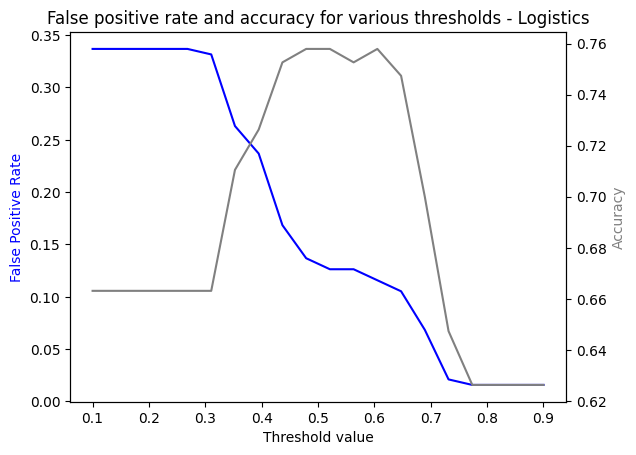

In [153]:
n_thresholds = 20
thresholds = np.linspace(.1, .9, n_thresholds)

accs = []
fps = []

y_pred_proba = pipe_log.predict_proba(X_test)


for th in thresholds:
    y_pred = y_pred_proba[:, 1] >= th # proba returns 2 columns, one for each category
    tp, fp, acc = calculate_performance(y_test, y_pred, verbose = False)
    accs.append(acc)
    fps.append(fp)

# Plot the two curves
fig, ax1 = plt.subplots()
ax1.set_title("False positive rate and accuracy for various thresholds - Logistics")
ax1.set_xlabel("Threshold value")
ax1.plot(thresholds, fps, color = "blue")
ax1.set_ylabel("False Positive Rate", color = "blue")
ax2 = ax1.twinx()
ax2.plot(thresholds, accs, color = "grey")
ax2.set_ylabel("Accuracy", color = "grey")
plt.show()

We can see that **False Positive rate decreases** and that the **optimal threshold is around 0.55 for best accuracy overall**.

We can use this technique to **selectively reduce the False Positive rate to low values**, satisfying the business needs of **identifying only good candidates for recipes**. This would however impact significantly the overall accuracy of the model, meaning many good candidates for high traffic recipes would be discarded.

The decision on where to have the threshold should come from a **discussion about how many recipes get created**: in case the flux of new recipes is abundant one can push the threshold further. Later on we discuss data quality and improvements that can be brough to the data to overcome some limitations around the binary classification model.

As an example, let's take a **0.7 threshold, which by the above graph should lead to a False positive rate as low as 5%**:

In [154]:
y_pred = y_pred_proba[:, 1] >= 0.7
true_ps["logs_th.7"], false_ps["logs_th.7"], accuracies["logs_th.7"] = calculate_performance(y_test, y_pred)

Recipes have been predicted correctly 68.42% of times.
True positive rate: 32.11%
False positive rate: 4.21%
Confusion matrix:
               Predicted - Low  Predicted - High
Actual - Low             36.3%              4.2%
Actual - High            27.4%             32.1%



With such a threshold we can get to **very low False positive rates (4.2%), but in this case we are only flagging 36.3%** of recipes as high traffic, whereas the initial dataset had over 60%. An example of how to **tune the model for selectivity** and associated impact in **volume of data discarded**.

## Binary tree classifier

For fun, Let's try a tree based model.

In [155]:
from sklearn.tree import DecisionTreeClassifier

pipe_tree = make_pipeline(StandardScaler(), DecisionTreeClassifier())
pipe_tree.fit(X_train, y_train)
y_pred = pipe_tree.predict(X_test)
true_ps["tree"], false_ps["tree"], accuracies["tree"] = calculate_performance(y_test, y_pred)

Recipes have been predicted correctly 68.42% of times.
True positive rate: 44.21%
False positive rate: 16.32%
Confusion matrix:
               Predicted - Low  Predicted - High
Actual - Low             24.2%             16.3%
Actual - High            15.3%             44.2%



We can see that the overall precision has dropped. Let's check an ensemble learning approach

## Gradiend Boosting Classifier

In [156]:
from sklearn.ensemble import GradientBoostingClassifier

pipe_xgb = make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators = 30))
pipe_xgb.fit(X_train, y_train)
y_pred = pipe_xgb.predict(X_test)
true_ps["xgb"], false_ps["xgb"], accuracies["xgb"] = calculate_performance(y_test, y_pred)

Recipes have been predicted correctly 75.26% of times.
True positive rate: 47.89%
False positive rate: 13.16%
Confusion matrix:
               Predicted - Low  Predicted - High
Actual - Low             27.4%             13.2%
Actual - High            11.6%             47.9%



Both above models perform worse than the baseline logistics one.

# Comparing model performances

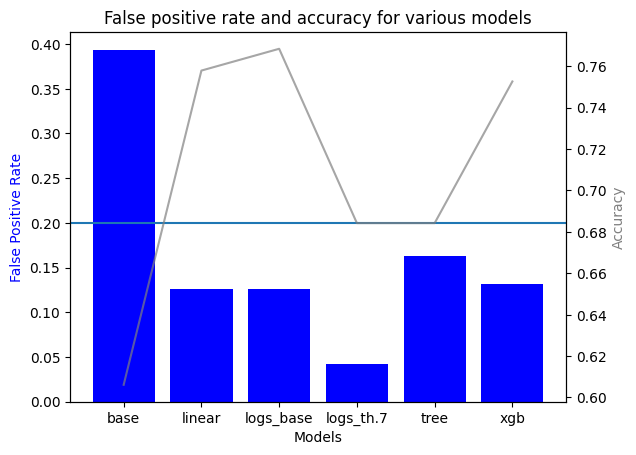

In [157]:
fig, ax1 = plt.subplots()
ax1.set_title("False positive rate and accuracy for various models")
ax1.set_xlabel("Models")
ax1.axhline(y = 0.2)

ax2 = ax1.twinx()
ax2.plot(list(accuracies.keys()), list(accuracies.values()), color = "grey", alpha = 0.7)

ax1.bar(list(false_ps.keys()), list(false_ps.values()), color = "blue")
ax1.set_ylabel("False Positive Rate", color = "blue")
ax2.set_ylabel("Accuracy", color = "grey")
plt.show()

From inspection it seems like the **Logistic Regression model is the winner**, which is not surprising given the model's fit for purpose in binary classification problems.

The situation might change is the recommendation we put forward to give the True / False nature of the high-traffic recipes into something **more nuanced (either more categories or using the number of visitors directly)**. More on this below.

# Responding to the business

The product manager required to identify which recipes would lead to high traffic. We have created models that are complessively **capable of identifying high and non-high recipes** at the desired performance.

The response to the business questions are:
- Yes **it is possible to predict high traffic recipes** with Data Science and doing so help to place high potential recipes high up the website, increasing traffic and thus subscriptions
- **Arriving at 80% accuracy should be possible** in the sense that a recipe flagged as being high-traffic has a change of not being so less than 20% of times (False Positive rate). 

## A note on indicators for this project going forward

We warn that using only the False Positive rate to evaluate the performance is not a good approach as pursuing solely so will exacerbate False Negatives (good recipes that are not identified). The decision on how selective this algorithm should be should also involve how many recipes we dispose and how many we need to display, as refusing many recipes might lead to not having enough to show.

# Recommendations to improve analysis quality

We believe that this project is well worth pursuing forward with the first results being satisfactory. However some **changes in the data intake** could lead to more capacity to identify recipes and therefore help PMs improve traffic and subscriptions.

## Get more nuance about high-traffic recipes - a quick win

The binary approach to the problem limits the nuances that recipes have: it puts quite different recipes in the same "team", winning team and losing team.

The analysis would benefit significantly bu using the real traffic numbers instead of a classification in high-traffic and not. Just by adding more categories (very low, low, median, high, very high) would already provide benefits, while the actual number of traffic would give more nuance.

For example, it is often the case few recipes have very high, astronomical popularity. These "viral" recipes might have particular features which our dataset did not allow to see, since 63% of recipes are high-traffic.

## Include more data

There seems to be more data available for these recipes (ingredients, process, price, photos). This data can be significant in identifying viral recipes, and should be included. Some of this data is in different formats, but our team can use new AI capabilities to treat them:
- Long text (ingredients, cooking method): NLP algorithms can be used to find most important words, topics, etc.
- Images: new AI capabilities allow to extract elements, colors, displays, etc. in order to also include this feature which gets more and more important

# Summary

We have performed a firs analysis on **predicting high traffic recipes with satisfactory results**, therefore the Data Science department is confident of the **value that can be unlocked pursuing this project further**. 

In this fiest step we have:
- Intaken the data and validated it
- Explored the data
- Preprocessed the data for Machine Learning
- Applied several models to predict high traffic recipes
- Selected a model and responded to the initial business question
- Proposed ways forward to improve the analysis and results